# Preprocessing data for fitting the SVM

#### Create water mask from Miami_water.png

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Function to load and preprocess images
def load_and_preprocess_image(image_path, scale_percent):
    image = cv2.imread(image_path)
    new_width = int(image.shape[1] * scale_percent / 100)
    new_height = int(image.shape[0] * scale_percent / 100)
    resized_image = cv2.resize(image, (new_width, new_height))
    return resized_image

#### Rescaling original image and it's water image

In [2]:
# Load the images
original_image_path = "../satellite-images/Miami.jpg"
water_mask_image_path = "../satellite-images/Miami_water.png"

scale_percent = 1
original_image_low_res = load_and_preprocess_image(original_image_path, scale_percent)
water_mask_image = cv2.imread(water_mask_image_path, cv2.IMREAD_GRAYSCALE)
water_mask_image_low_res = cv2.resize(water_mask_image, (original_image_low_res.shape[1], original_image_low_res.shape[0]))

#### Creating water mask from water image

Unique values in the water mask image after thresholding: [  0 255]


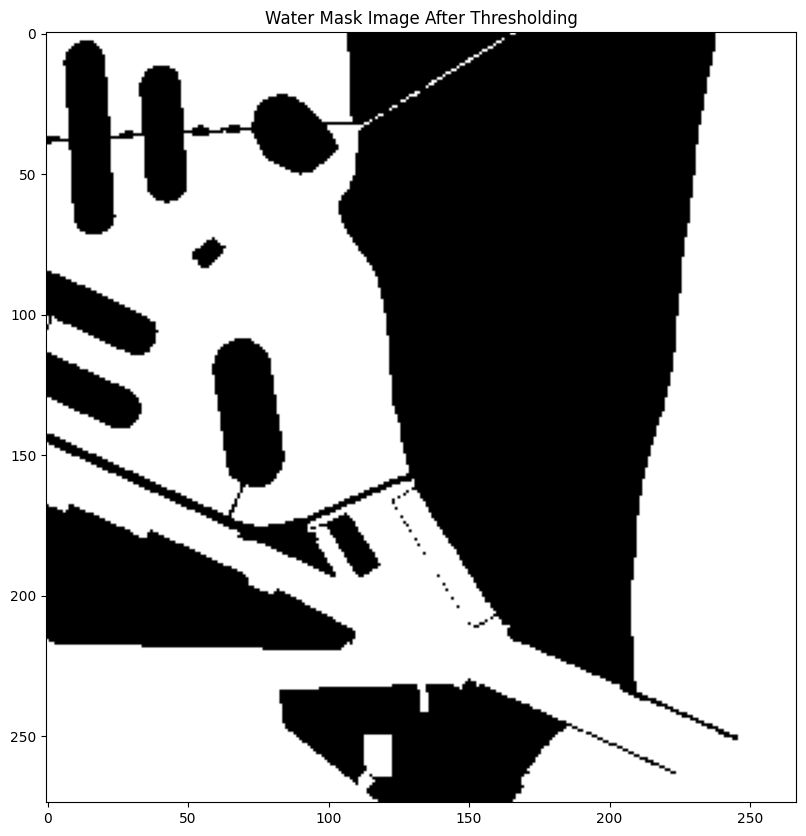

In [4]:
_, water_mask_binary = cv2.threshold(water_mask_image_low_res, 225, 255, cv2.THRESH_BINARY)

# # Ensure binary values (0 and 255 only)
# water_mask_binary = np.where(water_mask_binary > 0, 255, 0).astype(np.uint8)

unique_values = np.unique(water_mask_binary)
print(f"Unique values in the water mask image after thresholding: {unique_values}")

# Display the water mask image
plt.figure(figsize=(10, 10))
plt.title('Water Mask Image After Thresholding')
plt.imshow(water_mask_binary, cmap='gray')
plt.show()

#### Creating labels from water mask

In [5]:
labels = (water_mask_binary == 255).astype(np.uint8)

unique_labels = np.unique(labels)
print(f"Unique labels in the processed water mask: {unique_labels}")

Unique labels in the processed water mask: [0 1]


# Fitting the SVM

#### Flattening the rescaled original image and the labels

In [6]:
if len(unique_labels) < 2:
    print("The water mask image does not contain both water and land labels.")
else:
    flat_image = original_image_low_res.reshape((-1, 3))
    flat_labels = labels.flatten()

#### Fitting the SVM (with time measurements)

In [7]:
import time

start_time = time.time()
svm = SVC(kernel='rbf')  # Using RBF kernel
svm.fit(flat_image, flat_labels)
end_time = time.time()
print(f"Time spent fitting: {end_time - start_time}")

Time spent fitting: 8.024188041687012


#### Save the SVM model

In [8]:
import joblib

svm_model_path = '../svm-results/svm_model_1percent.pkl'
joblib.dump(svm, svm_model_path)
print(f"SVM model saved to {svm_model_path}")

SVM model saved to ../svm-results/svm_model_1percent.pkl


#### Predicting the water and land areas from the training image (with time measurements)

In [9]:
start_time = time.time()
predicted_labels = svm.predict(flat_image)
predicted_mask = predicted_labels.reshape(original_image_low_res.shape[:2])
end_time = time.time()
print(f"Time spent predicting: {end_time - start_time}")

Time spent predicting: 13.910614013671875


#### Calculate the accuracy of the SVM

In [10]:
# Calculate the accuracy
accuracy = accuracy_score(flat_labels, predicted_labels)

#### Display the original and predicted images

Accuracy of SVM mask compared to given water mask: 96.90%


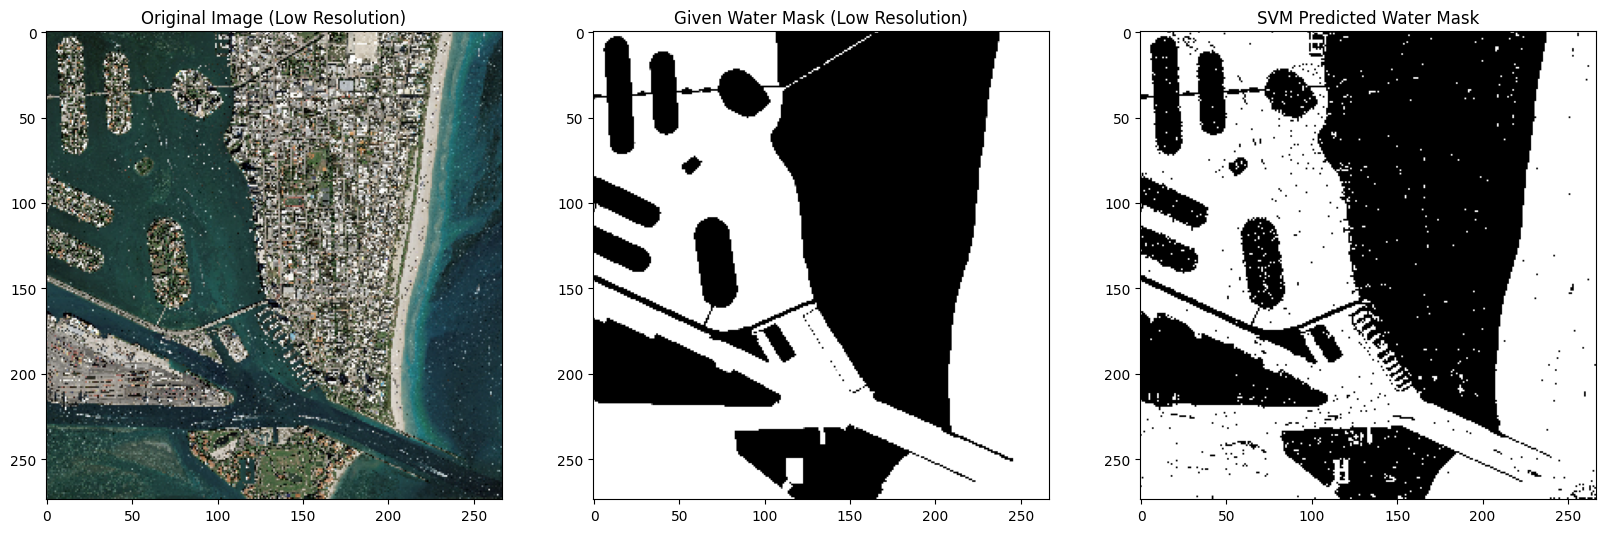

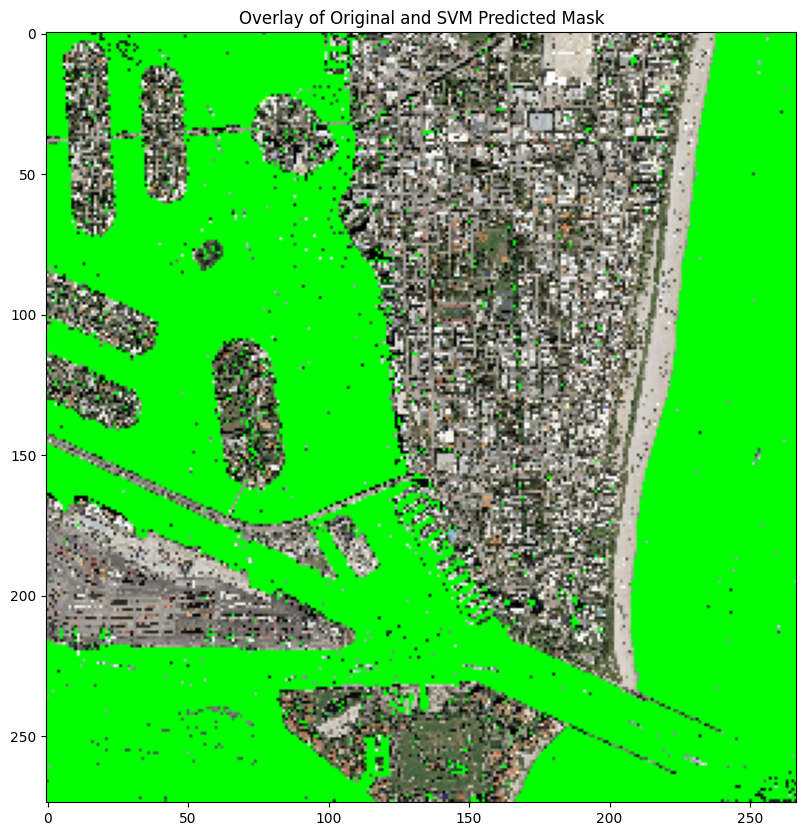

In [11]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.title('Original Image (Low Resolution)')
plt.imshow(cv2.cvtColor(original_image_low_res, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title('Given Water Mask (Low Resolution)')
plt.imshow(water_mask_image_low_res, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('SVM Predicted Water Mask')
plt.imshow(predicted_mask, cmap='gray')

# Overlay images to compare
overlay = original_image_low_res.copy()
overlay[predicted_mask == 1] = [0, 255, 0]  # Highlight predicted water areas in green

plt.figure(figsize=(10, 10))
plt.title('Overlay of Original and SVM Predicted Mask')
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))

# Print the accuracy
print(f"Accuracy of SVM mask compared to given water mask: {accuracy * 100:.2f}%")

plt.show()